In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:

date_format = '%Y-%m-%d %H:%M:%S'
column_types = {
    'global_trip_id': 'int64',                 # this should be unique, would be good to add a check to make sure later
    'local_trip_id': 'int64', 
    'duration': 'int64',                # length of trip in minutes
    # 'start_time': 'datetime64',         # start time of trip
    # 'end_time': 'datetime64',           # end time of trip
    'start_station': 'string',           # station ID where the trip originated
    'start_lat': 'float64',             # latitude of station where trip originated
    'start_lon': 'float64',             # longitude of station where trip originated
    'end_station': 'string',             # station ID where the trip terminated
    'end_lat': 'float64',               # latitude of station where trip terminated
    'end_lon': 'float64',               # longitude of station where trip terminated
    'bike_id': 'string',                 # locally unique integer that identifies the bike
    'plan_duration': 'string',           # length of plan the passholder is using (0 = walk-up)
    'trip_route_category': 'string',  # "Round Trip" for trips starting and ending at the same station or "One Way" for all other trips (check for others)
    'passholder_type': 'string',      # "Indego30", "Indego365", "IndegoFlex", or "Walk-up"
    'bike_type': 'string',             # "electric bike" or "classic bike"
    'file_origin': 'string'           # name of file that row came from
}
# import the clean dataset for all years, but only return round trips
iter_csv = pd.read_csv('indego_data/trips/clean/trips_clean_2017_2023.csv', 
                       iterator = True, 
                       chunksize=100000, 
                       dtype=column_types,
                       parse_dates=['start_time', 'end_time']
                       )

df = pd.concat([chunk[
                    (chunk['start_station'] == '3020') | # round trips
                    (chunk['end_station'] == '3020')
                ] 
                for chunk in iter_csv])

In [8]:
df = df[df['duration'] <= 1440] # minutes in a day since the data dictionary says trip lengths are capped at 24

In [128]:
# heatmap of the day grouped by hour and day of week
df['hour'] = df['start_time'].dt.hour
df['minute'] = df['start_time'].dt.minute * df['hour']
df['day_of_week'] = df['start_time'].dt.dayofweek
df['day_of_week_name'] = df['start_time'].dt.day_name()

In [129]:
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [133]:
# group by all rides starting at 3020
df_3020 = df[df['start_station'] == '3020']
start_group = df_3020.groupby(['start_station', 'day_of_week', 'day_of_week_name', 'hour']).size().reset_index(name='start_count')
# start_group['day_of_week'] = pd.Categorical(start_group['day_of_week_name'], categories=days_of_week_order, ordered=True)
# df['day_of_week_name'] = pd.Categorical(df['day_of_week_name'], categories=days_of_week_order, ordered=True)
df = df.sort_values(by='day_of_week')


In [134]:
start_group

,start_station,day_of_week,day_of_week_name,hour,start_count
0,3020,0,Monday,0,46
1,3020,0,Monday,1,27
2,3020,0,Monday,2,4
3,3020,0,Monday,3,8
4,3020,0,Monday,4,7
...,...,...,...,...,...
163,3020,6,Sunday,19,494
164,3020,6,Sunday,20,175
165,3020,6,Sunday,21,116
166,3020,6,Sunday,22,102


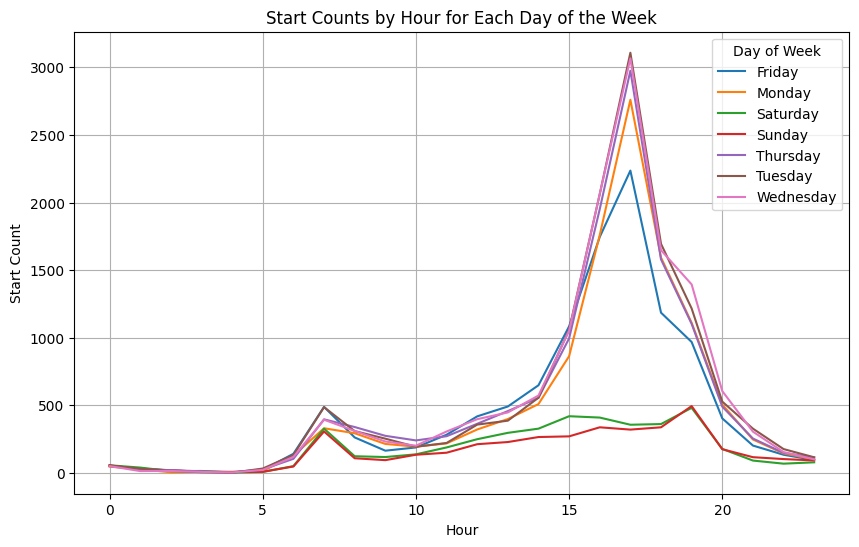

In [135]:
# create a scatter plot of the number of rides starting at 3020 by minute of day broken down by day of week name
# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(10, 6))

# Group by day_of_week and plot lines
for day, group in start_group.groupby('day_of_week_name'):
    group.plot(x='hour', y='start_count', label=day, ax=ax)

plt.title('Start Counts by Hour for Each Day of the Week')
plt.xlabel('Hour')
plt.ylabel('Start Count')
plt.legend(title='Day of Week', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

# ax.scatter(start_group['hour'], start_group['start_count'], c=start_group['day_of_week'], alpha=0.3)